In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from transformers import GPT2Model, GPT2Config, AdamW

# 시드 설정 (재현성을 위해)
torch.manual_seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/bs_1.csv', encoding='cp949', index_col=0)
df

,월,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 수온(°C),평균 유의 파고(m),평균 파주기(sec),한국,중국,일본,...,수출환적(TEU),수입물가지수,usd비율(Yuan/US),Dubai국제유가(US/배럴),강수량(mm),평균기온,평균최저기온,평균최고기온,?섏텧(TEU),?섏엯?섏쟻(TEU)
연도,,,,,,,,,,,,,,,,,,,,,
2014,1,6.253333,1023.482759,52.133333,14.053333,0.976667,6.336667,1,3,2,...,389979.75,128.15,6.105,104.0,9.6,5.0,1.2,9.7,353915.75,365515.00
2014,2,7.807143,1022.729630,65.392857,13.289286,1.650000,7.264286,1,2,1,...,350400.25,128.34,6.121,105.0,44.1,5.8,2.7,9.9,334478.00,334191.25
2014,3,6.080000,1019.790000,67.133333,13.096667,1.167742,6.425806,1,1,1,...,383563.50,127.66,6.152,104.4,136.7,9.8,6.2,14.5,405896.25,402860.75
2014,4,5.116667,1016.806667,72.866667,14.790000,0.877778,5.877778,0,3,1,...,401684.25,127.56,6.158,104.6,147.8,14.6,11.2,19.3,391681.50,402606.75
2014,5,5.283333,1012.036667,79.266667,16.340000,0.886667,5.896667,2,5,4,...,388978.25,127.70,6.169,105.6,145.9,18.7,15.4,23.2,396793.75,395188.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,1,7.464516,1014.648387,76.193548,23.861290,1.387097,4.706452,5,9,3,...,489668.00,123.42,6.753,80.4,79.2,3.8,-0.2,8.9,401093.00,417851.25
2023,2,6.096429,1022.039286,63.142857,21.375000,0.892857,4.135714,0,0,2,...,471788.00,123.78,6.945,82.1,30.0,6.8,2.9,11.8,410600.50,430718.00
2023,3,6.461290,1020.825806,62.806452,19.183871,0.996774,4.309677,1,1,1,...,540680.00,121.61,6.869,78.5,76.2,12.3,8.5,17.0,493589.25,465645.25


In [4]:
x = df.iloc[:,0:-1]
y = df.iloc[:,-1:]

In [5]:
# Training/Test ratio = 7:3
Train_ratio = 0.7
Test_ratio = 0.3

# Data Division
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [6]:
# Normalizing
minmax = MinMaxScaler()

train_x = minmax.fit_transform(train_x)
train_y = minmax.fit_transform(train_y)
test_x = minmax.fit_transform(test_x)
test_y = minmax.fit_transform(test_y)

# Check Data pre-processing
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (79, 20) (79, 1)
Test shape :  (34, 20) (34, 1)


In [7]:
x = minmax.fit_transform(x)
y = minmax.fit_transform(y)

In [8]:
# Torch Variable 형태로 변경(data/grad/grad_fn)
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Train : ",train_x_tensor.shape, train_y.shape)
print("After torch Variable shape_Test : ",test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Train :  torch.Size([79, 20]) (79, 1)
After torch Variable shape_Test :  torch.Size([34, 20]) torch.Size([34, 1])


In [9]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

print(train_x_tensor_final.shape, test_x_tensor_final.shape)

torch.Size([79, 1, 20]) torch.Size([34, 1, 20])


In [10]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

Tesla V100-SXM2-16GB


In [11]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=4, output_window=2, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            n = []
            start_x = stride*i
            end_x = start_x + input_window
            for j in y[start_x:end_x].cpu().numpy():
                for k in range(len(j)):
                    n.append(j[k])
            X[:,i] = n

            m = []
            start_y = stride*i + input_window
            end_y = start_y + output_window
            for j in y[start_y:end_y].cpu().numpy():
                for k in range(len(j)):
                    m.append(j[k])
            Y[:,i] = m

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y

        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [12]:
Y = Variable(torch.Tensor(y))

In [45]:
train_dataset = windowDataset(Y.reshape(-1,1), input_window=4, output_window=39, stride=1)
train_loader = DataLoader(train_dataset, batch_size=4)

In [46]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [47]:
import math

device = torch.device("cuda")
lr = 1e-4
model = TFModel(4, 39, 12, 4, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [48]:
from tqdm import tqdm

epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.029772: 100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


In [49]:
def evaluate():
    input = torch.tensor(Y.reshape(-1,1)[-4:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()

    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

<ipython-input-49-3d896c86308e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(Y.reshape(-1,1)[-4:]).reshape(1,-1,1).to(device).float().to(device)


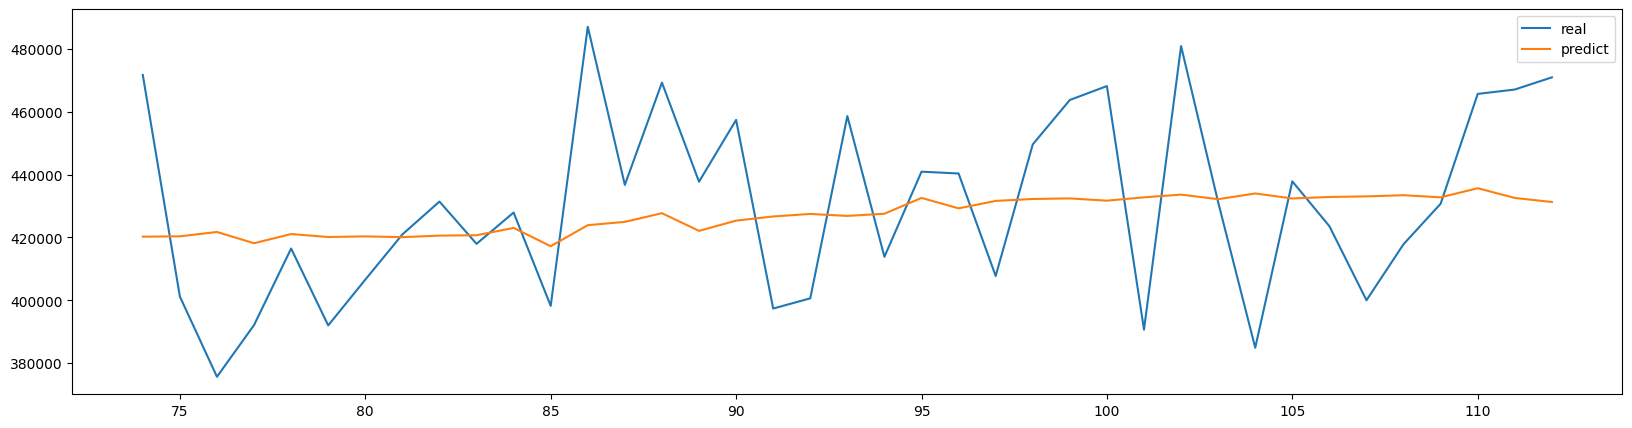

In [59]:
result = evaluate()
result = minmax.inverse_transform(result)[0]
real = y
real = minmax.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(range(74,113),real[74:], label="real")
plt.plot(range(74,113),result, label="predict")
plt.legend()
plt.show()

In [60]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-39:])

5.520450634837024